In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from abtem import *

# Scan and detect

Scanning imaging modes such as STEM works by rastering an electron probe across a sample pixel by pixel, and recording the scattering signal. As in earlier tutorials, we start by importing our graphene atoms and create a probe.

In [3]:
atoms = read('data/orthogonal_graphene.cif') 

probe = Probe(energy=80e3, semiangle_cutoff=30, focal_spread=60, defocus=50)

potential = Potential(atoms, sampling=.03)

## Line scan

The `LineScan` function scans the probe along a straight line between two points with a spacing given by the `gpts` parameter, while the `CustomScan` object can scan over any arbitrary region given as an array of positions.

Below we create a linescan object to scan between two atoms. The scan objects can be given as an argument of the plotting method of 2D arrays or the `show_atoms` function to visualise the scan region.

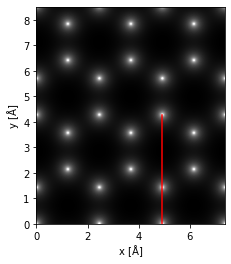

In [4]:
from abtem.scan import LineScan

linescan = LineScan(start=[2 * np.sqrt(3) * 1.42, 0], end=[2 * np.sqrt(3) * 1.42, 3 * 1.42], gpts=100)

potential.show(scans=linescan)

The scan object allows the creation of a generator of exit probes. The `max_batch` parameter controls the number  of probes propagated simultaneously; larger batches allows for better parallelism and hence speed. The actual speedup will depend on the number of threads, hence GPUs are better at taking advantage of large batches. The batch size should be balanced by the memory requirement.

The following code generates 50 probes at different positions and propagates them through the potential.

In [10]:
generator = probe._generate_probes(linescan, potential, max_batch=50)

first_index, last_index, exit_probes = next(generator)

The memory usage in bytes of the batch can be obtained from the memory usage property, hence in this case the batches take up 28 Mb of memory.

In [11]:
exit_probes.array.shape, exit_probes.array.nbytes * 1e-6

((50, 246, 285), 28.044)

## Detect

In real experiments, the exit probes are not directly detected. Correspondingly, in abTEM the way a signal is detected is controlled by detector objects. There are several different types of detectors, but for now we focus on the basic `AnnularDetector`, which depending on the choice of integration region can represent the detector used in bright-field, medium- and high-angle annular dark-field microscopy. The integration region is given by an inner and outer radius in radians; below we create three different types of detectors, and plot their respective integration regions.

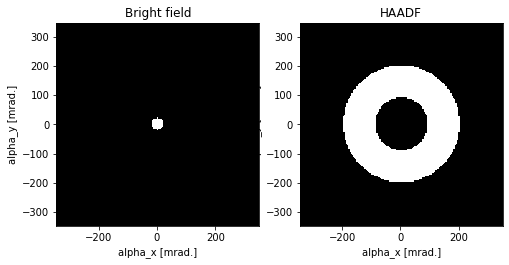

In [7]:
from abtem.detect import AnnularDetector
import matplotlib.pyplot as plt

bright = AnnularDetector(inner=0, outer=20)
haadf = AnnularDetector(inner=90, outer=200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

bright.show(potential.grid, probe.wavelength, ax=ax1, title='Bright field')
haadf.show(potential.grid, probe.wavelength, ax=ax2, title='HAADF');

The probes can be detected using the `.detect` method, this condenses each probe down to a single integrated intensity.

In [12]:
haadf.detect(exit_probes)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Usually, we would like to condense the exit probes during the scan in order to save memory. Hence, the typical syntax for simulating STEM experiment requires giving the detector(s) as an argument of the scan object.

In [13]:
measurements = probe.scan(linescan, [haadf, bright], potential, max_batch=20, pbar=True)

The output is a dictionary of measurements with one entry per detector.

In [14]:
measurements[bright]

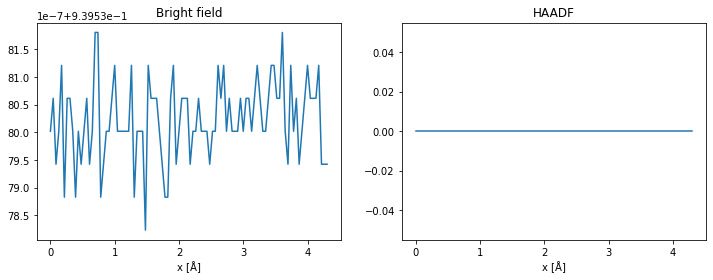

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
measurements[bright].show(ax=ax1, title='Bright field')
measurements[haadf].show(ax=ax2, title='HAADF')

In [16]:
measurements[haadf].write('linescan.hdf5')

'linescan.hdf5'

## Grid scan

The `GridScan` object is used essentially the same as the `LineScan` object, except the start and end coordinates now denote the corners of the grid. In the following, we scan over a tileable section of the potential. By specifying an output file for the detector, we write the measurements directly to disk as they are made.

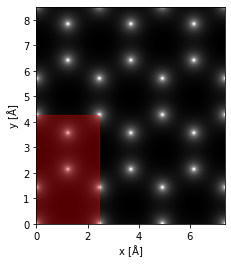

In [17]:
from abtem.scan import GridScan

detector = AnnularDetector(inner=86, outer=190, save_file='gridscan.hdf5')
gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=.1)

potential.show(scans=gridscan);

The number of positions in a densely sampled grid can obviously be large, hence it may be useful to show the progress as below.

In [18]:
measurement_files = probe.scan(gridscan, [detector], potential, max_batch=100, pbar=True)

In [19]:
measurement_files[detector]

'gridscan.hdf5'

We read back the measurements from disk and tile the image.

(<matplotlib.axes._subplots.AxesSubplot at 0x146baae50>,
 <matplotlib.image.AxesImage at 0x146af0220>)

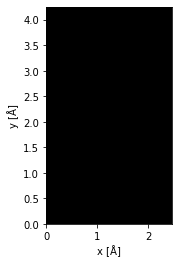

In [21]:
from abtem.measure import Measurement

measurement = Measurement.read('gridscan.hdf5')
measurement.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x146c62b80>,
 <matplotlib.image.AxesImage at 0x146c628b0>)

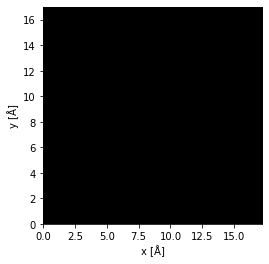

In [22]:
new_measurement = measurement.tile((7, 4))
new_measurement = new_measurement.interpolate(.04)

new_measurement.show()

It is not possible to save directly to an image file during the scan, however, it is straightforward to export the measurement as an image. 

In [23]:
new_measurement.save_as_image('gridscan.tif')

/Users/tomasusi/git/abTEM/abtem/measure.py:221: RuntimeWarning: invalid value encountered in true_divide
  array = (self.array - self.array.min()) / self.array.ptp() * np.iinfo(np.uint16).max
